In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path folder di Google Drive
drive_path = '/content/drive/My Drive/Dataset Uas'

# List nama file zip
zip_files = [
    'mit-bih-arrhythmia-database-1.0.0.zip',
    'mit-bih-noise-stress-test-database-1.0.0.zip'
]

# Ekstrak masing-masing file
for file in zip_files:
    file_path = os.path.join(drive_path, file)
    extract_path = os.path.join('/content', file.replace('.zip', ''))  # Ekstrak ke /content
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f'✅ Berhasil diekstrak: {file} ke {extract_path}')


✅ Berhasil diekstrak: mit-bih-arrhythmia-database-1.0.0.zip ke /content/mit-bih-arrhythmia-database-1.0.0
✅ Berhasil diekstrak: mit-bih-noise-stress-test-database-1.0.0.zip ke /content/mit-bih-noise-stress-test-database-1.0.0


In [ ]:
!ls /content/mit-bih-arrhythmia-database-1.0.0
!ls /content/mit-bih-noise-stress-test-database-1.0.0


mit-bih-arrhythmia-database-1.0.0
mit-bih-noise-stress-test-database-1.0.0


In [ ]:
!pip install wfdb

import wfdb
import numpy as np
import matplotlib.pyplot as plt


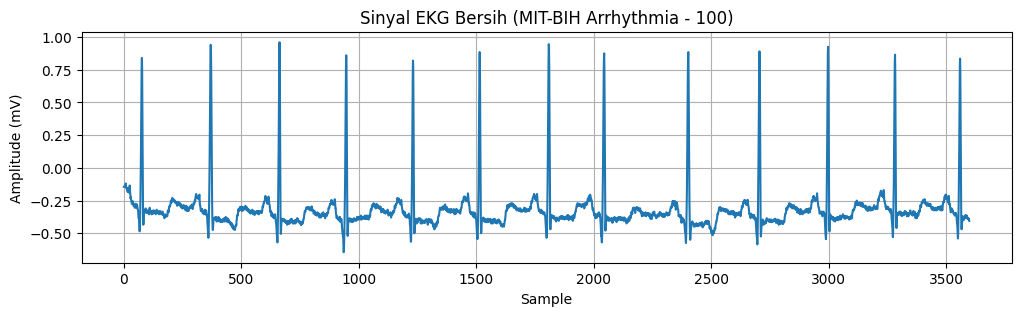

In [ ]:
# Ganti nomor rekaman sesuai file yang tersedia (misal: '100')
# The record files are in a subdirectory within the extracted folder.
# Let's assume the subdirectory is also named 'mit-bih-arrhythmia-database-1.0.0' for now,
# but you might need to adjust this based on the actual extracted structure.
record_clean = wfdb.rdrecord('/content/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/100', sampto=3600)

# Ambil 1 channel EKG (misal channel 0)
clean_signal = record_clean.p_signal[:, 0]

# Plot sinyal bersih
plt.figure(figsize=(12, 3))
plt.plot(clean_signal)
plt.title('Sinyal EKG Bersih (MIT-BIH Arrhythmia - 100)')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.grid(True)
plt.show()

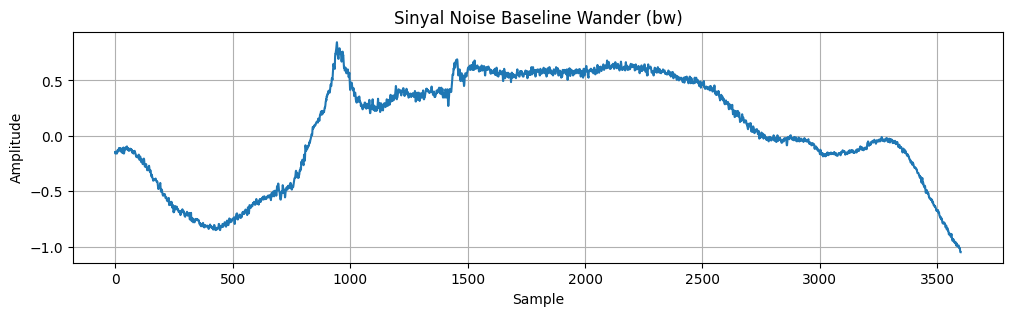

In [ ]:
# Noise file: no01.dat -> noise baseline wander (BW)
noise_record = wfdb.rdrecord('/content/mit-bih-noise-stress-test-database-1.0.0/mit-bih-noise-stress-test-database-1.0.0/bw', sampto=3600)
noise_signal = noise_record.p_signal[:, 0]

# Plot sinyal noise
plt.figure(figsize=(12, 3))
plt.plot(noise_signal)
plt.title('Sinyal Noise Baseline Wander (bw)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
!ls /content/mit-bih-noise-stress-test-database-1.0.0

mit-bih-noise-stress-test-database-1.0.0


In [ ]:
!ls /content/mit-bih-noise-stress-test-database-1.0.0/mit-bih-noise-stress-test-database-1.0.0

118e00.atr  118e18.atr	119e00.atr  119e18.atr	ANNOTATORS  ma.xws
118e00.dat  118e18.dat	119e00.dat  119e18.dat	bw.dat	    nstdb.doc
118e00.hea  118e18.hea	119e00.hea  119e18.hea	bw.hea	    nstdbgen
118e00.xws  118e18.xws	119e00.xws  119e18.xws	bw.hea-     nstdbgen-
118e06.atr  118e24.atr	119e06.atr  119e24.atr	bw.xws	    nstdb.txt
118e06.dat  118e24.dat	119e06.dat  119e24.dat	em.dat	    old
118e06.hea  118e24.hea	119e06.hea  119e24.hea	em.hea	    RECORDS
118e06.xws  118e24.xws	119e06.xws  119e24.xws	em.hea-     SHA256SUMS.txt
118e12.atr  118e_6.atr	119e12.atr  119e_6.atr	em.xws
118e12.dat  118e_6.dat	119e12.dat  119e_6.dat	ma.dat
118e12.hea  118e_6.hea	119e12.hea  119e_6.hea	ma.hea
118e12.xws  118e_6.xws	119e12.xws  119e_6.xws	ma.hea-


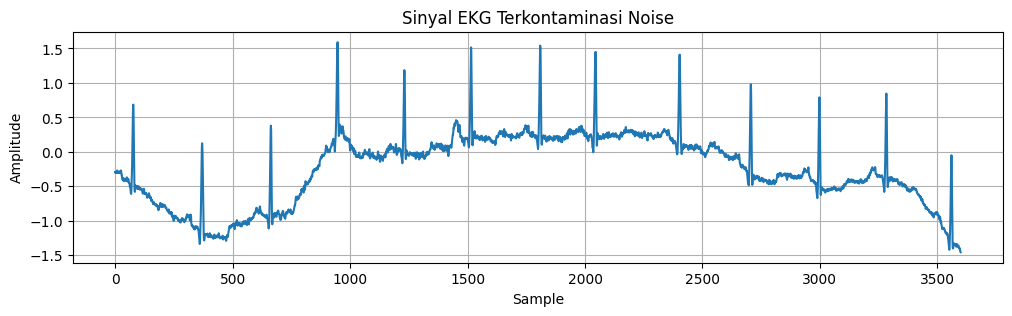

In [ ]:
# Samakan panjang sinyal
min_len = min(len(clean_signal), len(noise_signal))
clean_signal = clean_signal[:min_len]
noise_signal = noise_signal[:min_len]

# Gabungkan (kontaminasi sinyal bersih)
noisy_signal = clean_signal + noise_signal

# Plot gabungan sinyal EKG berderau
plt.figure(figsize=(12, 3))
plt.plot(noisy_signal)
plt.title('Sinyal EKG Terkontaminasi Noise')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=360, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [ ]:
fs = 360  # Frekuensi sampling EKG
filtered_signal = apply_bandpass_filter(noisy_signal, lowcut=0.5, highcut=40.0, fs=fs)


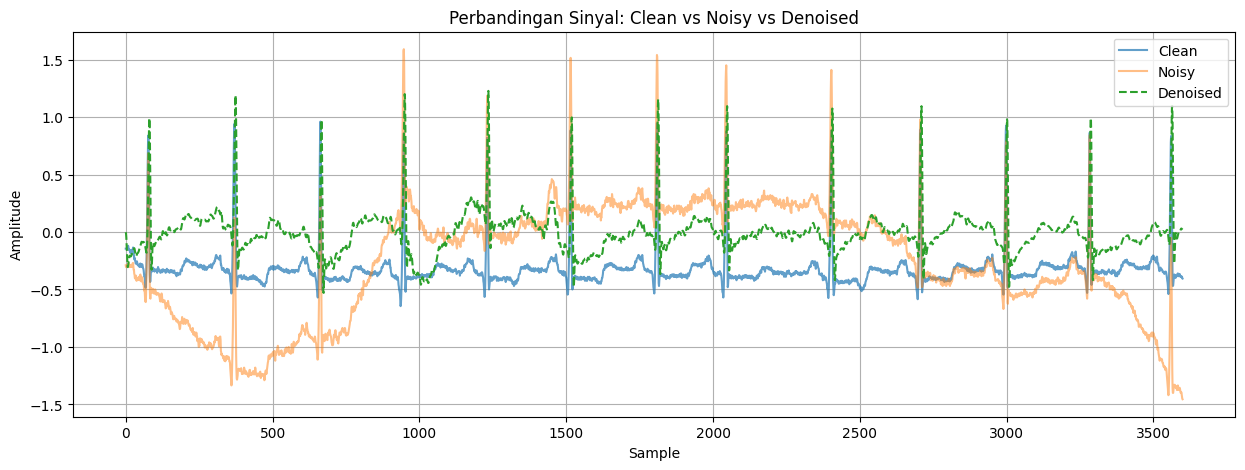

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(clean_signal, label='Clean', alpha=0.7)
plt.plot(noisy_signal, label='Noisy', alpha=0.5)
plt.plot(filtered_signal, label='Denoised', linestyle='--')
plt.legend()
plt.title('Perbandingan Sinyal: Clean vs Noisy vs Denoised')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(clean_signal, filtered_signal))
print(f"✅ RMSE: {rmse:.4f}")


✅ RMSE: 0.3694


In [ ]:
prd = np.sqrt(np.sum((clean_signal - filtered_signal)**2) / np.sum(clean_signal**2)) * 100
print(f"✅ PRD: {prd:.2f}%")


✅ PRD: 101.95%


In [ ]:
def calculate_snr(clean, processed):
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - processed) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

snr = calculate_snr(clean_signal, filtered_signal)
print(f"✅ SNR: {snr:.2f} dB")


✅ SNR: -0.17 dB


In [ ]:
import pandas as pd

# Buat dataframe hasil
df_result = pd.DataFrame({
    'Clean': clean_signal,
    'Noisy': noisy_signal,
    'Denoised': filtered_signal
})

# Simpan ke CSV
df_result.to_csv('submission.csv', index=False)
print("✅ File submission.csv berhasil dibuat!")


✅ File submission.csv berhasil dibuat!


In [ ]:
!pip install PyWavelets

import pywt


In [ ]:
def wavelet_denoise(signal, wavelet='db6', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Thresholding detail coefficients
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:])
    denoised = pywt.waverec(coeffs, wavelet)
    return denoised[:len(signal)]  # Potong jika lebih panjang


In [ ]:
denoised_wavelet = wavelet_denoise(noisy_signal)


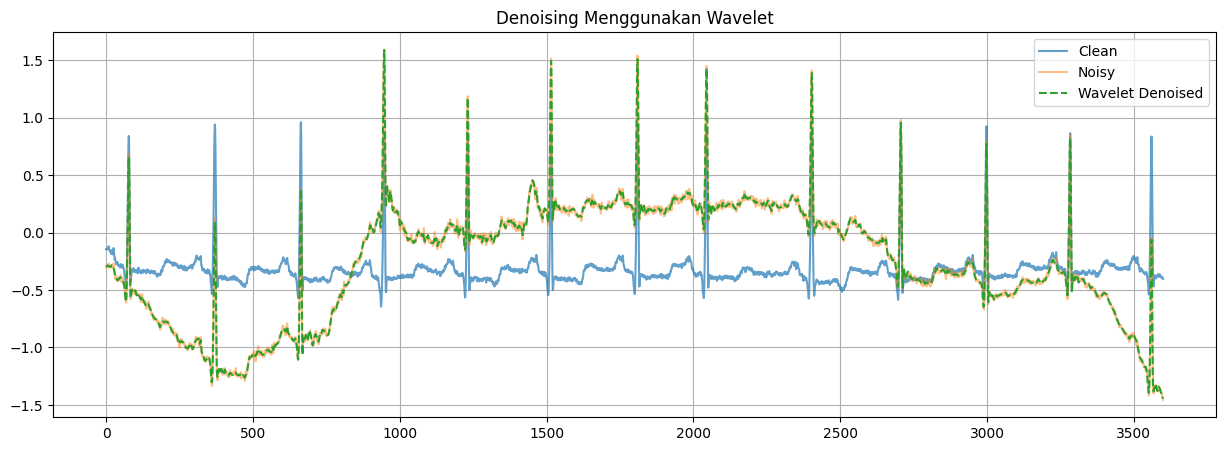

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(clean_signal, label='Clean', alpha=0.7)
plt.plot(noisy_signal, label='Noisy', alpha=0.5)
plt.plot(denoised_wavelet, label='Wavelet Denoised', linestyle='--')
plt.legend()
plt.title('Denoising Menggunakan Wavelet')
plt.grid(True)
plt.show()


In [ ]:
rmse_wav = np.sqrt(mean_squared_error(clean_signal, denoised_wavelet))
prd_wav = np.sqrt(np.sum((clean_signal - denoised_wavelet)**2) / np.sum(clean_signal**2)) * 100
snr_wav = calculate_snr(clean_signal, denoised_wavelet)

print(f"✅ Wavelet RMSE: {rmse_wav:.4f}")
print(f"✅ Wavelet PRD: {prd_wav:.2f}%")
print(f"✅ Wavelet SNR: {snr_wav:.2f} dB")


✅ Wavelet RMSE: 0.4872
✅ Wavelet PRD: 134.45%
✅ Wavelet SNR: -2.57 dB


In [ ]:
df_wavelet = pd.DataFrame({
    'Clean': clean_signal,
    'Noisy': noisy_signal,
    'Wavelet_Denoised': denoised_wavelet
})

df_wavelet.to_csv('submission_wavelet.csv', index=False)
print("✅ File submission_wavelet.csv berhasil disimpan.")


✅ File submission_wavelet.csv berhasil disimpan.


In [ ]:
def wavelet_denoise(signal, wavelet='db6', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Thresholding pada detail coefficients (hilangkan noise)
    threshold = np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = (pywt.threshold(i, threshold, mode='soft') for i in coeffs[1:])

    # Rekonstruksi sinyal
    denoised_signal = pywt.waverec(coeffs, wavelet)

    return denoised_signal


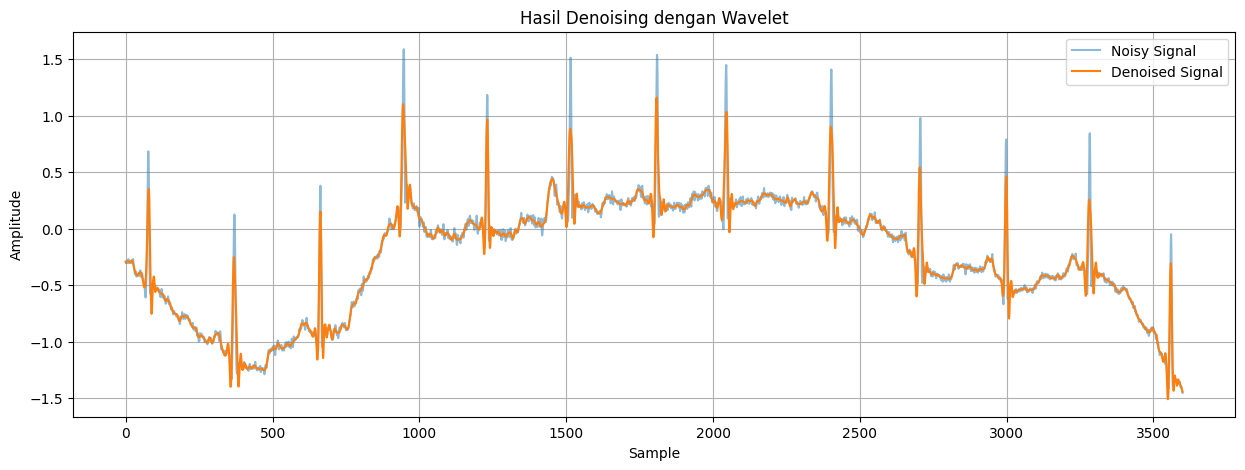

In [ ]:
# Proses denoising
denoised_signal = wavelet_denoise(noisy_signal)

# Potong jika lebih panjang setelah rekonstruksi
denoised_signal = denoised_signal[:len(noisy_signal)]

# Visualisasi sinyal hasil denoising
plt.figure(figsize=(15, 5))
plt.plot(noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(denoised_signal, label='Denoised Signal', linewidth=1.5)
plt.legend()
plt.title('Hasil Denoising dengan Wavelet')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

def compute_snr(clean, noisy):
    noise = noisy - clean
    signal_power = np.sum(clean ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

rmse = np.sqrt(mean_squared_error(clean_signal, denoised_signal))
snr_before = compute_snr(clean_signal, noisy_signal)
snr_after = compute_snr(clean_signal, denoised_signal)

print(f"RMSE Denoised vs Clean: {rmse:.4f}")
print(f"SNR Before Denoising: {snr_before:.2f} dB")
print(f"SNR After Denoising : {snr_after:.2f} dB")


RMSE Denoised vs Clean: 0.4938
SNR Before Denoising: -2.57 dB
SNR After Denoising : -2.69 dB


In [ ]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



In [ ]:
cutoff_freq = 45.0  # Hz
fs = 360  # sampling rate

filtered_signal = butter_lowpass_filter(noisy_signal, cutoff=cutoff_freq, fs=fs)


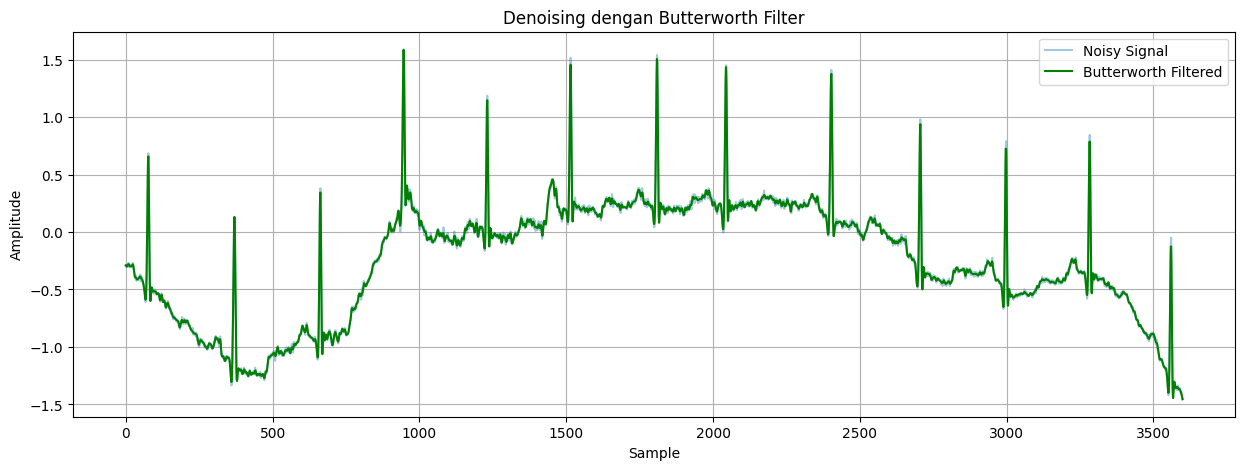

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(noisy_signal, label='Noisy Signal', alpha=0.4)
plt.plot(filtered_signal, label='Butterworth Filtered', color='green', linewidth=1.5)
plt.legend()
plt.title('Denoising dengan Butterworth Filter')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


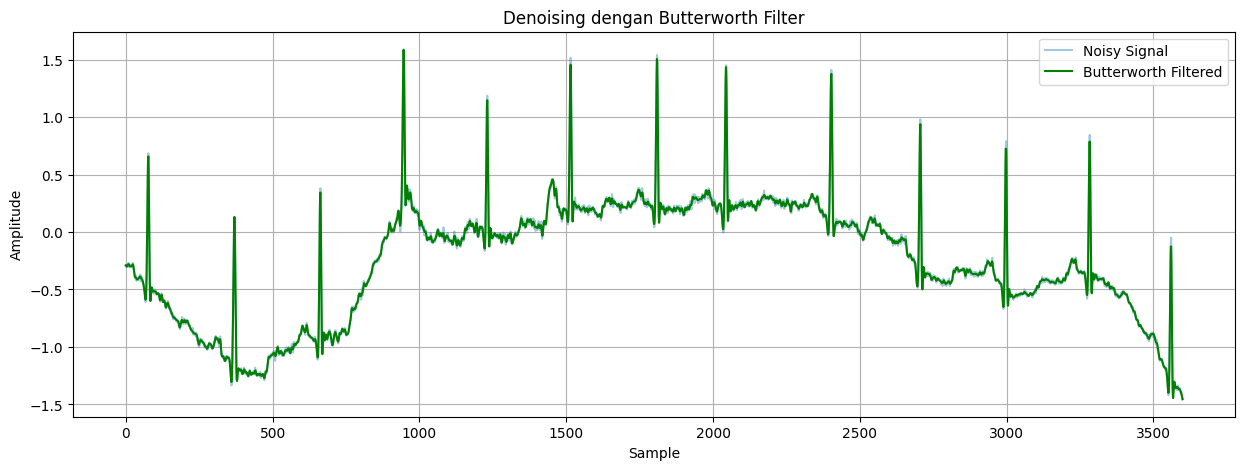

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(noisy_signal, label='Noisy Signal', alpha=0.4)
plt.plot(filtered_signal, label='Butterworth Filtered', color='green', linewidth=1.5)
plt.legend()
plt.title('Denoising dengan Butterworth Filter')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
rmse_butter = np.sqrt(mean_squared_error(clean_signal, filtered_signal))
snr_butter = compute_snr(clean_signal, filtered_signal)

print(f"RMSE Butterworth: {rmse_butter:.4f}")
print(f"SNR Butterworth: {snr_butter:.2f} dB")
print(f"SNR Wavelet    : {snr_after:.2f} dB")


RMSE Butterworth: 0.4874
SNR Butterworth: -2.57 dB
SNR Wavelet    : -2.69 dB


In [ ]:
# Simpan hasil denoising Butterworth
np.save("/content/drive/My Drive/Dataset Uas/ekg_denoised_butterworth.npy", filtered_signal)

# Simpan hasil denoising wavelet
np.save("/content/drive/My Drive/Dataset Uas/ekg_denoised_wavelet.npy", denoised_signal)


In [ ]:
# Untuk Butterworth
df_butter = pd.DataFrame({'Butterworth_Denoised': filtered_signal})
df_butter.to_csv("/content/drive/My Drive/Dataset Uas/ekg_denoised_butterworth.csv", index=False)

# Untuk Wavelet
df_wavelet = pd.DataFrame({'Wavelet_Denoised': denoised_signal})
df_wavelet.to_csv("/content/drive/My Drive/Dataset Uas/ekg_denoised_wavelet.csv", index=False)
